<a href="https://colab.research.google.com/github/nikas-belogolov/plant-disease-identification-ML/blob/master/Plant_disease_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Plant disease identification

##### Author: Nikas Belogolov, י"א 6

---

## Introduction

This project aims to develop a neural network-based image classifier to identify diseases in pepper and potato plants. Leveraging deep learning techniques, the model will be trained to distinguish between healthy plants and those affected by various diseases. This application is crucial for early disease detection and effective crop management, potentially leading to higher yields and reduced losses.

### Goals

1. Identify Diseases: Develop a robust model capable of identifying diseases in pepper and potato plants from images.
2. Learn Image Identification with Neural Networks: Understand the process of building, training, and evaluating an image classification model using neural networks.
3. Understand and Use SHAP Values: Learn what SHAP (SHapley Additive exPlanations) values are and how to use them for model interpretability.

### Dataset

For this project I've used the [PlantVillage Dataset](https://www.kaggle.com/datasets/emmarex/plantdisease) from Kaggle.

The dataset contains images of pepper, tomato and potato plants categorized into different classes, including healthy plants and various disease conditions.

The dataset was truncated to 5 classes for simplicity (2 classes for pepper plants and 3 for potato plants), and split into training, validation, and test sets to ensure the model's robustness and generalizability.

## Setup

In [2]:
!pip install tensorflow numpy seaborn scikit-learn pandas pathlib matplotlib shap Pillow

In [3]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
import pandas as pd
import shap
from PIL import Image
import random
import shutil
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

Local and cloud environments config, and constant variables.

In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
  from google.colab import drive
  drive.mount('/content/drive')
  dir = "/content/drive/MyDrive/PlantVillage_Dataset"
  split_dir = dir + "/split"
  models_dir = dir + "/models"
else:
  dir = "C:\\Users\\belog\\Documents\\PlantVillage_Dataset"
  split_dir = dir + "\\split"
  models_dir = dir + "\\models"

CLASSES = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
IMG_SIZE = (128, 128)
EPOCHS = 100
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train Test Validation Split
Here we split the dataset from kaggle into three folders: training folder, validation folder and testing folder.

The ratio for splitting is: 75% for training, 15% for testing and 10% for validation.

In [ ]:
#הגדרת תיקיות המקור והיעד של הפיצול.
source_dir = "/content/drive/MyDrive/PlantVillage_Dataset"
destination_dir = "/content/drive/MyDrive/PlantVillage_Dataset/split"

#הגדרת התיקיות החדשות בתיקיית היעד והמחלקות השונות
new_folders = ['train', 'test', 'val']

for folder in new_folders:
    for class_name in CLASSES:
        new_folder_path = os.path.join(destination_dir, folder, class_name)
        Path(new_folder_path).mkdir(parents=True, exist_ok=True)

def split_and_copy_files(source_dir, destination_dir, split_ratios):
    for class_name in CLASSES:
        class_files = os.listdir(os.path.join(source_dir, class_name))
        random.shuffle(class_files)

        num_files = len(class_files)
        train_split = int(num_files * split_ratios[0])
        test_split = int(num_files * split_ratios[1])

        for i, file_name in enumerate(class_files):
            if i < train_split:
                dest_folder = os.path.join(destination_dir, 'train', class_name)
            elif i < train_split + test_split:
                dest_folder = os.path.join(destination_dir, 'test', class_name)
            else:
                dest_folder = os.path.join(destination_dir, 'val', class_name)

            shutil.copy(os.path.join(source_dir, class_name, file_name), dest_folder)
#מימדי הפיצול כמתואר בתא הטקסט מעל תא הקוד
split_ratios = [0.75, 0.15, 0.10]

split_and_copy_files(source_dir, destination_dir, split_ratios)

print("Files copied successfully!")

## Explore Dataset
The first graph is the number of images in training, validation and testing datasets.

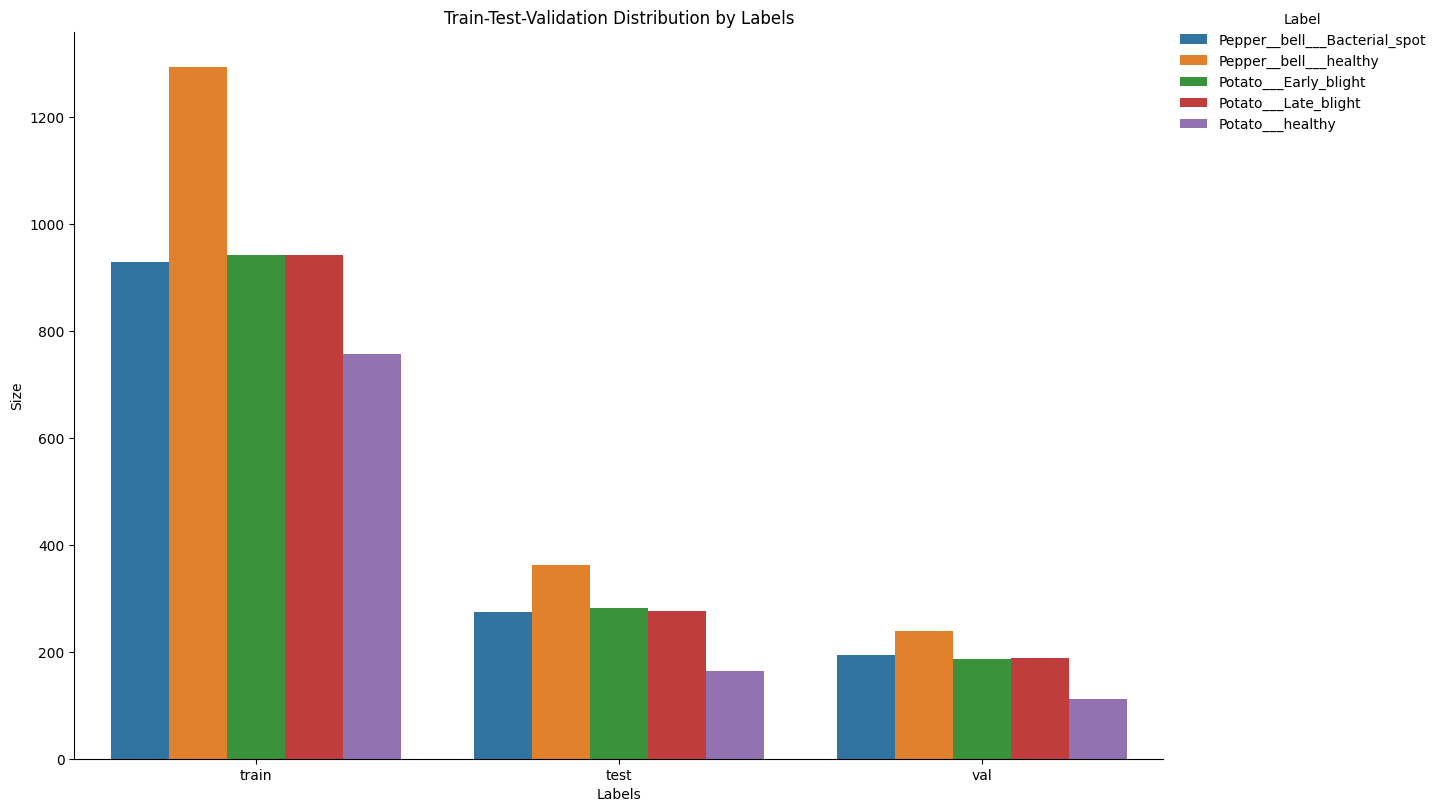

In [ ]:
# Sample data (replace this with your actual data)
data = {
    'Label': CLASSES * 3,
    'Split': [],
    'Size': []
}

for split_folder in os.listdir(split_dir):
  for i in range(0,5):
    data["Split"].append(split_folder)
  for class_name in os.listdir(f"{split_dir}/{split_folder}"):
    data["Size"].append(len(os.listdir(f"{split_dir}/{split_folder}/{class_name}")))

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot using catplot
ax = sns.catplot(x='Split', y='Size', hue='Label', data=df, kind='bar', height=8, aspect=1.5)
plt.title('Train-Test-Validation Distribution by Labels')
plt.ylabel('Size')
plt.xlabel('Labels')
sns.move_legend(ax, "upper right")
plt.show()


The second is random images, drawn from each class.

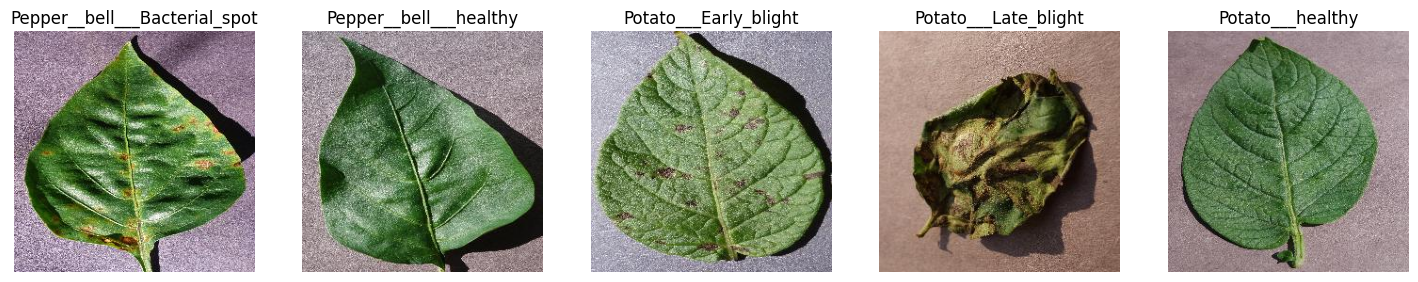

In [ ]:
random_images = []

for class_name in CLASSES:
  choice = random.choice(os.listdir(dir + "/" + class_name))
  random_images.append(f"{dir}/{class_name}/{choice}")

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for i, path in enumerate(random_images):
    # Load and display the image
    img = plt.imread(path)
    axes[i].imshow(img)
    axes[i].set_title(CLASSES[i])
    axes[i].axis('off')

plt.show()

## Normalization
The dataset is normalized to have pixel values ranging from 0 to 1 instead of 0 to 255, which speeds up the fitting process later.

In [33]:
directory = "/content/drive/MyDrive/PlantVillage_Dataset/split"

# Initialization of ImageDataGenerator with rescale
img_data_generator = ImageDataGenerator(rescale=1./225)

# Define batch size
batch_size = 32

# Set up the image generators using flow_from_directory
train_generator = img_data_generator.flow_from_directory(
    split_dir + '/train',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = img_data_generator.flow_from_directory(
    split_dir + '/val',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = img_data_generator.flow_from_directory(
    split_dir + '/test',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical')

Found 4861 images belonging to 5 classes.
Found 917 images belonging to 5 classes.
Found 1360 images belonging to 5 classes.


## Verify that all images are valid
Some images were found to be corrupted, so remove all of the corrupted images.

In [ ]:
# Iterate through each folder
for folder in os.listdir(split_dir + "/train"):
    # Get a list of all image files in the folder
    image_files = os.listdir(split_dir + "/train/" + folder)

    # Iterate through each image file
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(split_dir + "/train/" + folder, image_file)

        # Try to open the image using PIL
        try:
            image = Image.open(image_path)
        except Exception as e:
            os.remove(image_path)
            print(f"Error opening image '{image_path}': {e}")

Error opening image '/content/drive/MyDrive/PlantVillage_Dataset/split/train/Pepper__bell___Bacterial_spot/cef63924-0e7e-4df3-9b8c-bdc80f3215f2___JR_B.Spot 3376.JPG': cannot identify image file '/content/drive/MyDrive/PlantVillage_Dataset/split/train/Pepper__bell___Bacterial_spot/cef63924-0e7e-4df3-9b8c-bdc80f3215f2___JR_B.Spot 3376.JPG'


KeyboardInterrupt: 

## Model Building

In [6]:
def create_model(input_shape):
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='ReLU'),
      tf.keras.layers.Dense(128, activation='ReLU'),
      tf.keras.layers.Dense(64, activation='ReLU'),
      tf.keras.layers.Dense(32, activation='ReLU'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

def save_model(model_name):
  model.save(f'{models_dir}/{model_name}.keras')

def load_model(model_name):
  return tf.keras.models.load_model(f'{models_dir}/{model_name}')


## Model Architecture and Parameters
### Model Architecture
- **Input Layer**: The model takes an input shape of (128, 128, 3), which corresponds to images of size 128x128 pixels with three color channels (RGB). This input layer does not modify the data but passes it to the next layer.
- **Flatten Layer**: The Flatten layer converts the multi-dimensional input data into a one-dimensional array, making it suitable for the dense layers that follow.
- **Dense Layers**: Following the flatten layer, there are 4 dense layers with ReLU activation. Each dense layer has less neurons than the layer before it.
- **Output Layer**: The output layer uses the softmax activation function, and produces a probability distribution over the 5 classes for classification.

### Parameters

- Learning Rate: The model uses the Adam optimizer with a learning rate specified by the LEARNING_RATE variable.

- Number of Epochs: The model is trained for a number of epochs specified by the EPOCHS variable. Each epoch represents one complete pass through the training dataset.

- Optimizer: The model uses the Adam optimizer, which adapts the learning rate during training for improved convergence.

- Loss Function: The model is compiled with the Categorical Crossentropy loss function, which is suitable for multi-class classification problems.

- Metrics: The model tracks accuracy as a metric to evaluate its performance during training and validation.

### Callbacks

- Model Checkpoint: The ModelCheckpoint callback saves the best version of the model based on validation loss, preventing overfitting by preserving the best weights.

- Early Stopping: The EarlyStopping callback monitors the validation loss and stops training if it does not improve for a specified number of epochs (patience), as defined by the EARLY_STOPPING_PATIENCE variable.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 12626565 (48.17 MB)
Trainable params: 1262

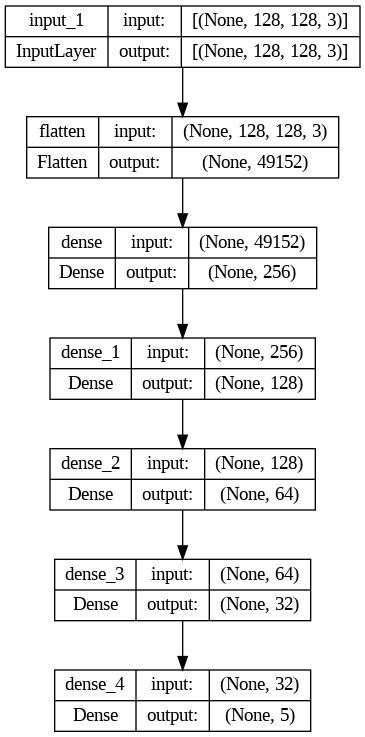

In [ ]:
input_shape = IMG_SIZE + (3,)

model = create_model(input_shape)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

## Model Training

In [ ]:
CHECKPOINT_FILEPATH="/content/drive/MyDrive/PlantVillage_Dataset/checkpoints"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_FILEPATH, save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE)

history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[stop_early, checkpoint])

Epoch 1/100
152/152 [==============================] - 1249s 8s/step - loss: 2.0018 - accuracy: 0.4697 - val_loss: 0.9848 - val_accuracy: 0.6260
Epoch 2/100
152/152 [==============================] - 72s 471ms/step - loss: 1.0187 - accuracy: 0.6217 - val_loss: 0.8677 - val_accuracy: 0.6903
Epoch 3/100
152/152 [==============================] - 67s 438ms/step - loss: 0.9173 - accuracy: 0.6571 - val_loss: 0.9378 - val_accuracy: 0.6543
Epoch 4/100
152/152 [==============================] - 64s 422ms/step - loss: 0.8224 - accuracy: 0.6972 - val_loss: 0.8788 - val_accuracy: 0.6979
Epoch 5/100
152/152 [==============================] - 71s 465ms/step - loss: 0.7158 - accuracy: 0.7373 - val_loss: 0.7775 - val_accuracy: 0.6947
Epoch 6/100
152/152 [==============================] - 67s 443ms/step - loss: 0.6985 - accuracy: 0.7426 - val_loss: 0.6506 - val_accuracy: 0.7721
Epoch 7/100
152/152 [==============================] - 66s 432ms/step - loss: 0.6892 - accuracy: 0.7517 - val_loss: 1.1143 - 

## Training history graphs

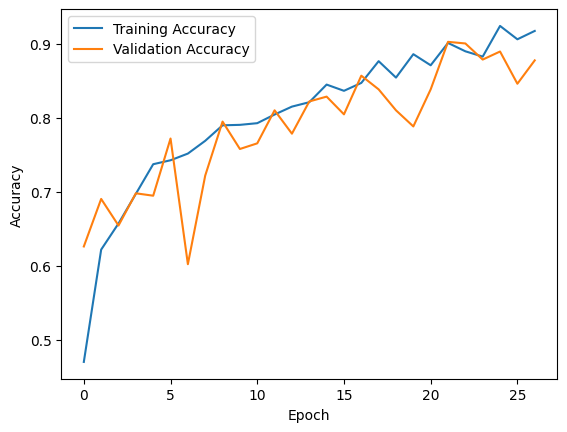

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color="green")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

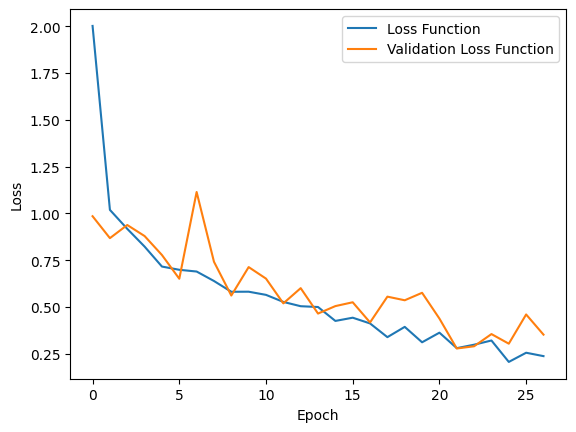

In [ ]:
# Plot the accuracy over epochs
plt.plot(history.history['loss'], label='Loss Function', color="green")
plt.plot(history.history['val_loss'], label='Validation Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.locator_params(axis="x", integer=True, tight=True)
plt.show()

## Saving and Loading Model

In [ ]:
save_model("best_model_50EPCH")

In [7]:
models = []
print("enter model number: ")
for i, model in enumerate(os.listdir(models_dir)):
  print(f'{i} {model}')
  models.append(model)

model = load_model(f'{models[int(input())]}')

enter model number: 
0 best_model_50EPCH.keras
0


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/PlantVillage_Dataset/checkpoints")

## Model Evaluation

### Evaluate Model

In [92]:
test_generator = img_data_generator.flow_from_directory(
    split_dir + '/test',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

# Get true labels from the test generator
true_labels = test_generator.classes

# Get predictions from the model using the test generator
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

Found 1360 images belonging to 5 classes.
43/43 [==============================] - 12s 269ms/step


In [93]:
print("test loss, test acc:", model.evaluate(test_generator))

43/43 [==============================] - 12s 267ms/step - loss: 0.3395 - accuracy: 0.8801
test loss, test acc: [0.3395175337791443, 0.8801470398902893]


In [103]:
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=CLASSES))

Classification Report:
                                precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.81      0.83      0.82       275
       Pepper__bell___healthy       0.99      0.79      0.88       363
        Potato___Early_blight       0.92      1.00      0.96       282
         Potato___Late_blight       0.77      0.94      0.85       276
             Potato___healthy       0.97      0.85      0.90       164

                     accuracy                           0.88      1360
                    macro avg       0.89      0.88      0.88      1360
                 weighted avg       0.89      0.88      0.88      1360



### Confusion Matrix

Confusion Matrix:
[[229   3   5  38   0]
 [ 49 288   3  19   4]
 [  0   0 281   1   0]
 [  1   0  14 260   1]
 [  2   0   3  20 139]]


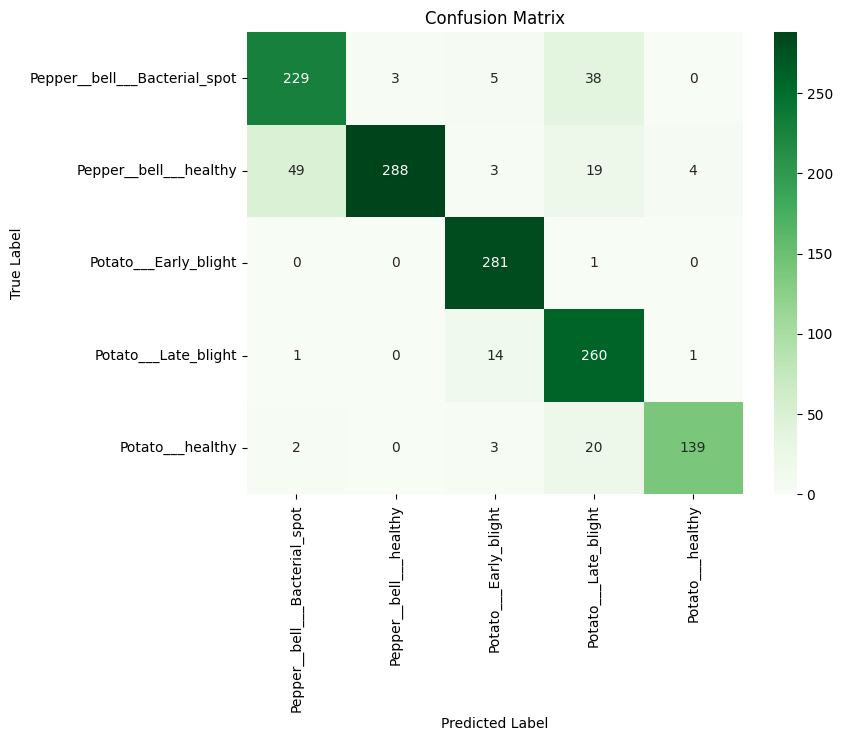

In [106]:
print("Confusion Matrix:")

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Explaining model outputs with SHAP values

### What are SHAP values?
SHAP (SHapley Additive exPlanations) values are a method used in machine learning to understand how individual features contribute to model predictions. They quantify the impact of each feature on a model's output for a specific data point, helping to interpret the model's decisions better.

### How I integrated them into my project?

To integrate SHAP into my project, I had to do a little of research on what kind of input the SHAP explainer function takes in.

I've found that it takes a numpy array of the image pixels, so I've converted the images into a numpy array.

In [9]:
x_train = []
y_train = []

x_test = []
y_test = []

### Convert images to numpy array and save to .npz file

In [14]:


for _, label in enumerate(os.listdir(split_dir + "/train")):
  for _, file in enumerate(os.listdir(split_dir + "/train/" + label)):
    image = Image.open(split_dir + "/train/" + label + "/" + file)
    image = image.resize(IMG_SIZE)
    image = image.convert('RGB')
    image_array = np.array(image)
    x_train.append(image_array)
    y_train.append(CLASSES.index(label))

for _, label in enumerate(os.listdir(split_dir + "/test")):
  for _, file in enumerate(os.listdir(split_dir + "/test/" + label)):
    image = Image.open(split_dir + "/test/" + label + "/" + file)
    image = image.resize(IMG_SIZE)
    image = image.convert('RGB')
    image_array = np.array(image)
    x_test.append(image_array)
    y_test.append(CLASSES.index(label))

# save as DataX or any other name. But the same element name is to be used while loading it back.
np.savez("/content/drive/MyDrive/PlantVillage_Dataset/mnistlikedataset.npz",x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### Load images data from .npz file

In [96]:
path = "/content/drive/MyDrive/PlantVillage_Dataset/mnistlikedataset.npz"
x_train, y_train, x_test, y_test
with np.load(path) as data:
    #load DataX as train_data
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

print(x_train.shape)

(4861, 128, 128, 3)


In [97]:
num_classes = len(CLASSES)
input_shape = IMG_SIZE + (3,)

In [98]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
# test_df = tf.keras.utils.to_categorical(test_df, num_classes)

x_train shape: (4861, 128, 128, 3)
4861 train samples
1360 test samples


### Initialize SHAP Explainer

In [99]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 700, replace=False)]

# explain predictions of the model on three images
explainer  = shap.DeepExplainer(model, background)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


### Compute SHAP Values

In [101]:
shap_values = explainer.shap_values(x_test[0:5])

### Plot SHAP Values

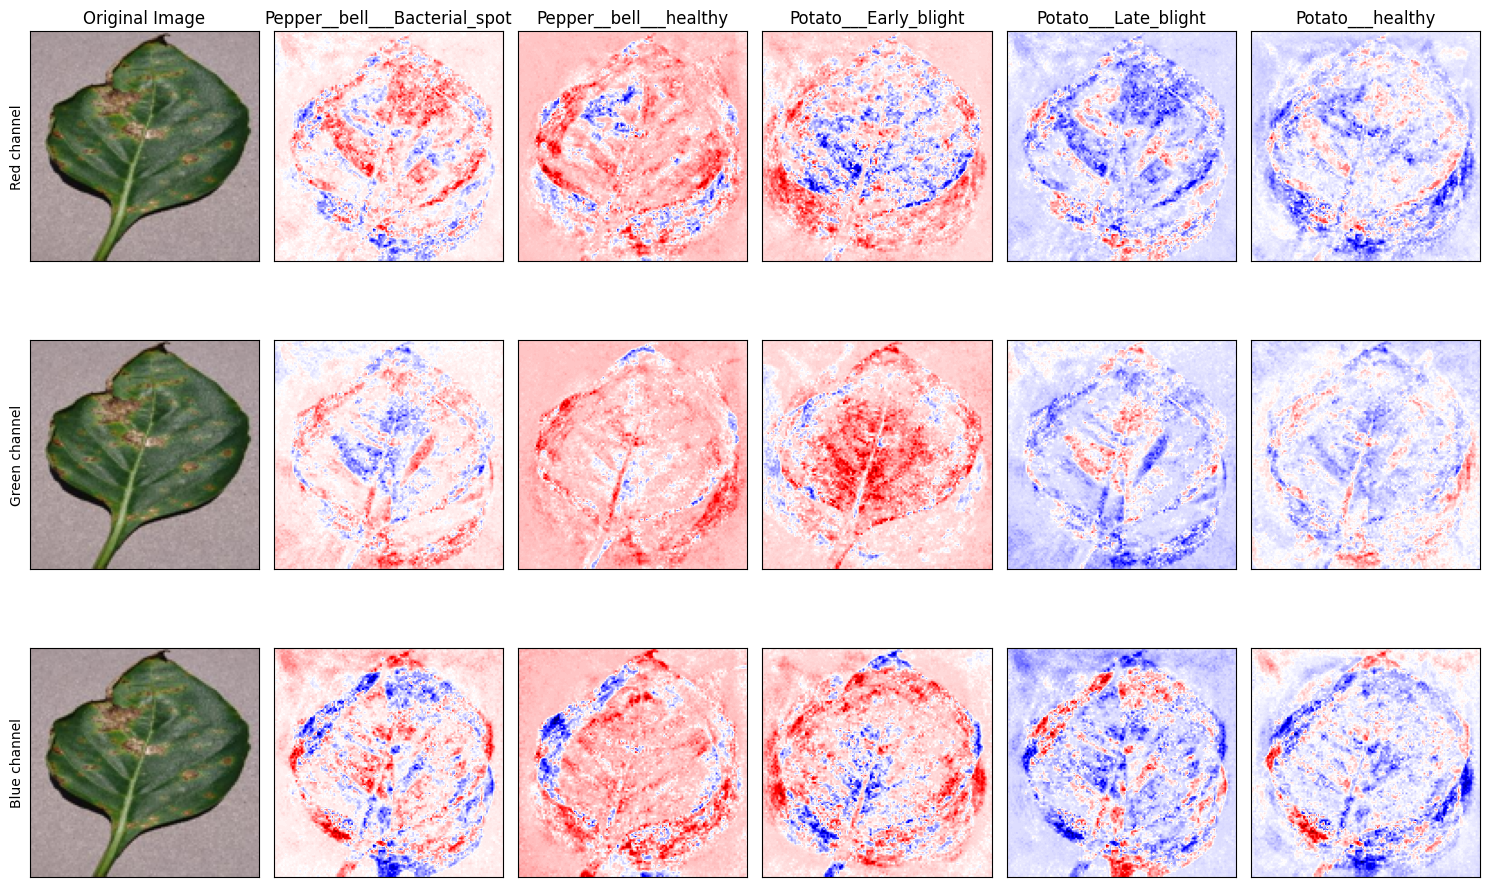

In [105]:
random_index = random.randint(0, 4)

shap_value = shap_values[random_index]

fig, axs = plt.subplots(3, 6, figsize=(15, 10))

axs[0, 0].set_title(f"Original Image")

for i, channel in enumerate(["Red", "Green", "Blue"]):
    axs[i, 0].imshow(x_test[random_index,:,])
    axs[i, 0].set(ylabel=f"{channel} channel")

for ax in axs.flat:
    ax.set_yticks([])
    ax.set_xticks([])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()

for class_idx, cls in enumerate(CLASSES):
  shap_values_normalized = (shap_value[:,:,:,class_idx] - shap_value[:,:,:,class_idx].min()) / (shap_value[:,:,:,class_idx].max() - shap_value[:,:,:,class_idx].min())

  for channel_idx, channel in enumerate(["Red", "Green", "Blue"]):
      axs[channel_idx, class_idx + 1].imshow(shap_values_normalized[:,:,channel_idx], cmap='seismic', vmin=0, vmax=1)
      if channel_idx == 0:
          axs[channel_idx, class_idx + 1].set_title(cls)
plt.tight_layout()
plt.show()

# Discussion and Conclusions

## Discussion

### Confusion Matrix

The model demonstrates robust performance with an overall accuracy of 88%. It excels particularly in identifying **Potato___Early_blight** and has high precision in classifying healthy pepper and potato plants.

The primary area for improvement is reducing misclassifications between **Pepper__bell___Bacterial_spot**, **Pepper__bell___healthy**, and **Potato___Late_blight**. Despite these misclassifications, the model is highly effective for the task of multi-class classification of plant diseases.

### Classification Report

**Precision** - measures how many of the positive predictions made by the model are actually correct.

**Recall** - measures how well the model identifies all relevant instances.

**F1** - A measure that balances precision and recall. It's the harmonic mean of precision and recall.

The model was precise in predicting healthy pepper and potato plants, but was struggling to identify all instances of them.

It was predicting more false positives of unhealthy plants, but more or less it was great at finding most instances of plants with diseases.

```
                                precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.81      0.83      0.82       275
       Pepper__bell___healthy       0.99      0.79      0.88       363
        Potato___Early_blight       0.92      1.00      0.96       282
         Potato___Late_blight       0.77      0.94      0.85       276
             Potato___healthy       0.97      0.85      0.90       164

                     accuracy                           0.88      1360
                    macro avg       0.89      0.88      0.88      1360
                 weighted avg       0.89      0.88      0.88      1360
```

### SHAP

In this project I've used for the first time SHAP (SHapley Additive exPlanations), which are used to explain the output of any machine learning model.

Although SHAP can provide good insight into a model, it didn't help me that much it this project to understand how the model works and why it returns the output it does. But I will use SHAP in the future projects to understand the model outputs.

### Limitations

It is hard to identify similar looking plants, and even harder to differentiate between diseases, as one plant can have multiple similar looking diseases.

But even with those limitations, the model has a close to 90% accuracy with similar looking plants and diseases.

### Future Work

Future work for this project could be:

*   Expanding the dataset (More plant species, diseases).
*   Improving the model architecture.
*   Deploying the model in real-world application.

## Conclusions

This project successfully demonstrated the application of deep learning techniques for identifying diseases in pepper and potato plants using image classification.

The neural network model achieved a high level of accuracy, effectively distinguishing between healthy and diseased plants.

These contributions highlight the potential of AI-driven solutions in early disease detection and effective crop management, paving the way for improved agricultural productivity and reduced crop losses.